In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")
matplotlib.style.use("dark_background")

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

In [5]:
# read in the data
column_names = [
    "MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"
]
raw_data = pd.read_csv(url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
dataset = raw_data.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.iloc[32]

MPG               25.0
Cylinders          4.0
Displacement      98.0
Horsepower         NaN
Weight          2046.0
Acceleration      19.0
Model Year        71.0
Origin             1.0
Name: 32, dtype: float64

In [7]:
# pre-process!
# remove rows where the horsepower is "?"
dataset = dataset.dropna()

# convert the "origin" column into regions
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="", prefix_sep="")
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
dataset["USA"]

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    0
395    1
396    1
397    1
Name: USA, Length: 392, dtype: uint8

In [12]:
# show how many we have
print(len(dataset))

392


In [13]:
dataset.iloc[:10]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,0,0,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,0,0,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,0,0,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,0,0,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,0,0,1


In [14]:
# divide into train/validate/test groups
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

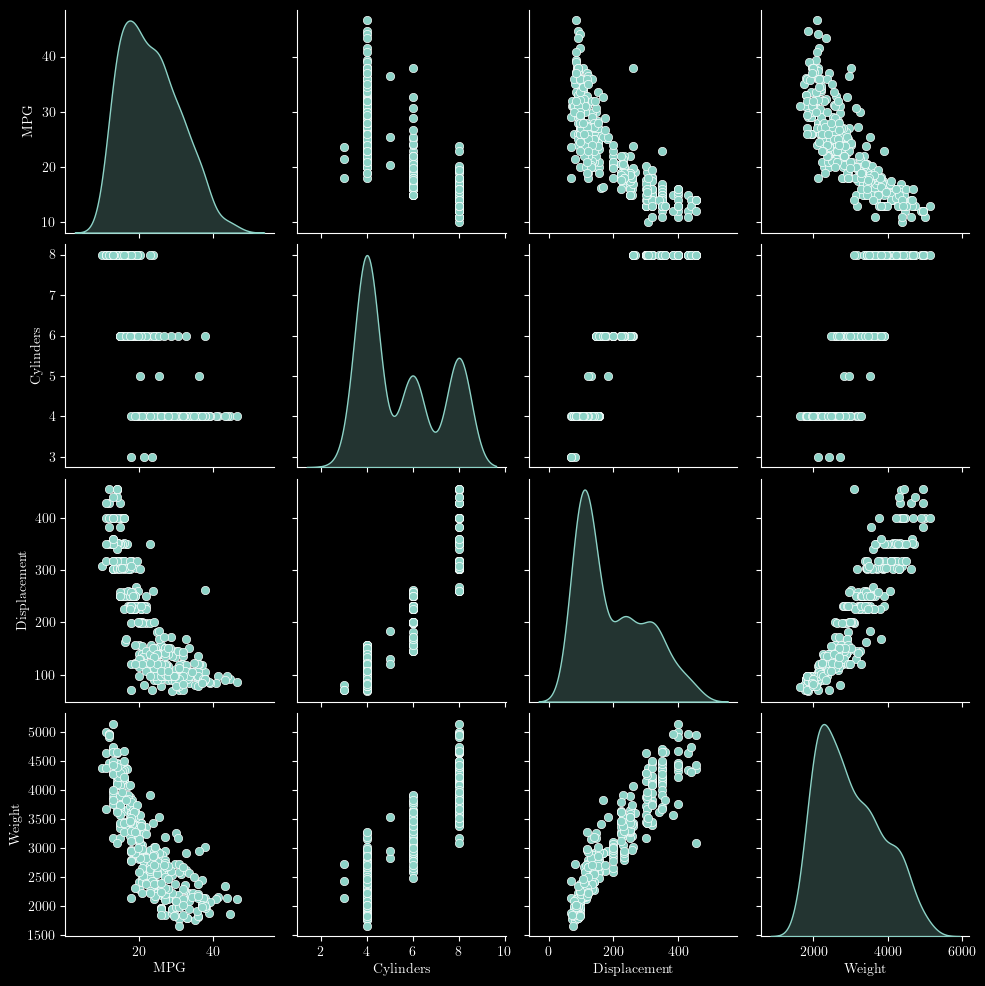

In [15]:
# inspect the data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [16]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

In [18]:
# Normalization
train_dataset.describe().transpose()[["mean", "std"]]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [19]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

Metal device set to: Apple M2
[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025195e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


2022-10-24 16:34:46.171963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-24 16:34:46.172743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-24 16:34:46.241488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-24 16:34:46.305061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:34:46.317329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [20]:
# start with linear regression on horsepower
horsepower = np.array(train_features["Horsepower"])

horsepower_normalizer = Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

2022-10-24 16:37:20.146287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:37:20.157009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [21]:
# build the model in keras
horsepower_model = tf.keras.Sequential(
    [horsepower_normalizer, Dense(units=1)]
)

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [22]:
# train the "neural network"
horsepower_model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss="mean_absolute_error",
)

In [23]:
%%time 
history = horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2,
)

/Users/plaplant/mambaforge/envs/tf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-10-24 16:40:02.299375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:40:02.437200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2.55 s, sys: 1.44 s, total: 3.99 s
Wall time: 3.06 s


In [24]:
# visualize training using the `history` object
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804338,4.179973,95
96,3.805721,4.183473,96
97,3.809164,4.216979,97
98,3.805947,4.182541,98
99,3.805277,4.190702,99


In [25]:
# plot the loss
def plot_loss(history, filename):
    fig = plt.figure()
    ax = plt.gca()
    
    ax.plot(history.history["loss"], label="loss")
    ax.plot(history.history["val_loss"], label="val_loss")
    ax.set_ylim((0, 10))
    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("Error [MPG]", fontsize=20)
    ax.legend(loc=0, fontsize=14)
    ax.tick_params(which="both", labelsize=14)
    ax.grid(True)
    fig.savefig(filename, bbox_inches="tight", transparent=True)

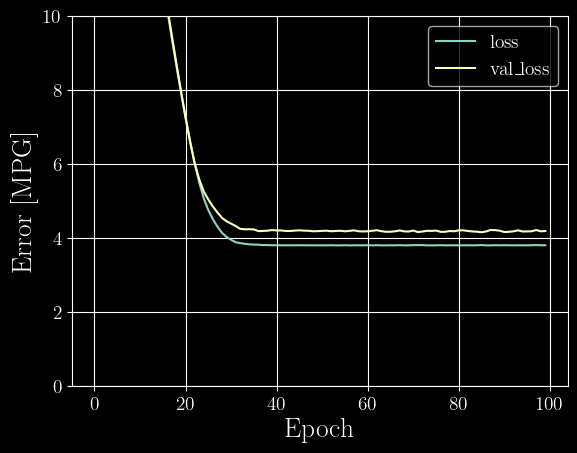

In [26]:
plot_loss(history, "horsepower_loss.pdf")

In [27]:
# run on the test results
test_results = {}

test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features["Horsepower"],
    test_labels,
    verbose=0,
)

In [28]:
# compute the regression
x = tf.linspace(0.0, 250, num=1000)
y = horsepower_model.predict(x)

32/32 [==============================] - 0s 1ms/step


2022-10-24 16:44:45.918601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [29]:
def plot_horsepower(x, y, filename):
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(train_features["Horsepower"], train_labels, label="Data")
    ax.plot(x, y, label="Predictions", color="w")
    ax.set_xlabel("Horsepower", fontsize=20)
    ax.set_ylabel("MPG", fontsize=20)
    ax.legend(loc=0, fontsize=14)
    ax.tick_params(which="both", labelsize=14)
    fig.savefig(filename, bbox_inches="tight", transparent=True)

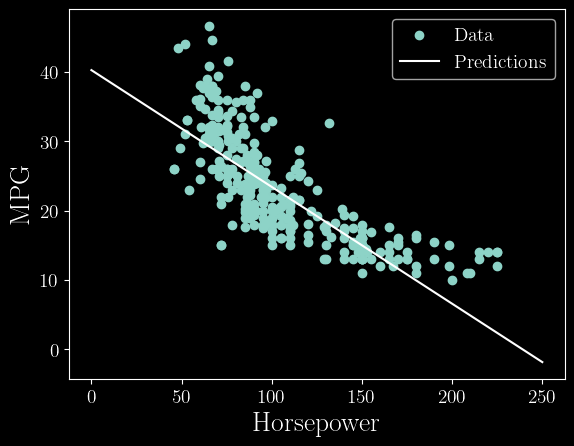

In [30]:
plot_horsepower(x, y, "horsepower_regress.pdf")

In [31]:
# multiple inputs
linear_model = Sequential(
    [normalizer, Dense(units=1)]
)

In [32]:
# make sure weights have the right size--should give something with shape (9, 1)
print(linear_model.layers[1].kernel)

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.3305087 ],
       [-0.70058835],
       [-0.5292651 ],
       [ 0.21543676],
       [ 0.00272417],
       [ 0.06739575],
       [-0.31697896],
       [ 0.02908093],
       [-0.13455379]], dtype=float32)>


In [33]:
# compile the model
linear_model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss="mean_absolute_error",
)

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2,
)

/Users/plaplant/mambaforge/envs/tf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-10-24 16:46:46.251044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:46:46.353122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2.59 s, sys: 1.44 s, total: 4.03 s
Wall time: 3.1 s


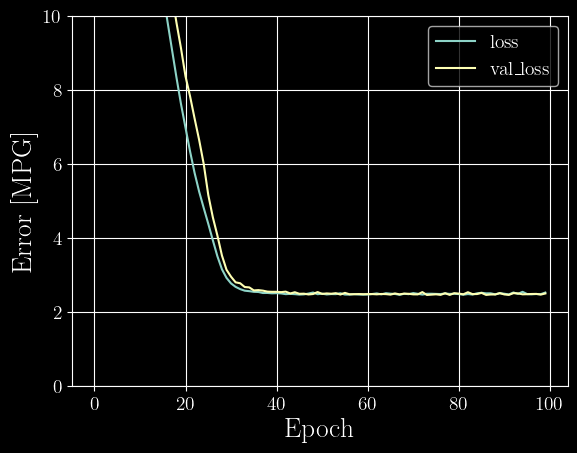

In [35]:
plot_loss(history, "linear_model_loss.pdf")

In [36]:
test_results["linear_model"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

# Deep Neural Networks

In [37]:
# define function for building and compiling the model
def build_and_compile_model(norm):
    model = Sequential(
        [
            norm,
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(1),
        ]
    )
    
    model.compile(
        loss="mean_absolute_error",
        optimizer=Adam(0.001),
    )
    
    return model

In [38]:
# design and implement a neural network
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [39]:
%%time
history = dnn_horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

/Users/plaplant/mambaforge/envs/tf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-10-24 16:50:18.705611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:50:18.852671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.09 s, sys: 1.52 s, total: 4.61 s
Wall time: 3.68 s


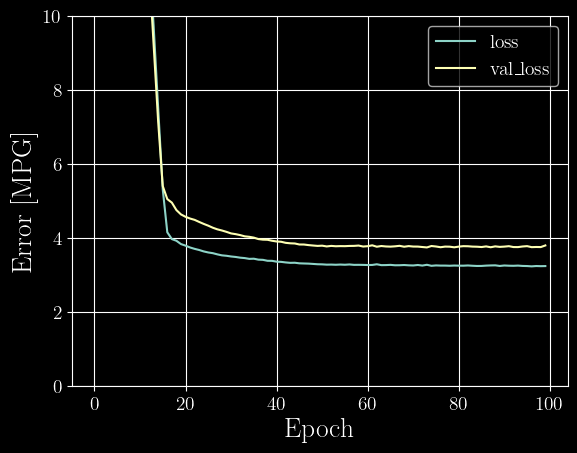

In [40]:
plot_loss(history, "horsepower_dnn_loss.pdf")

In [41]:
x = tf.linspace(0.0, 250, num=1000)
y = dnn_horsepower_model.predict(x)

32/32 [==============================] - 0s 2ms/step


2022-10-24 16:51:10.820508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


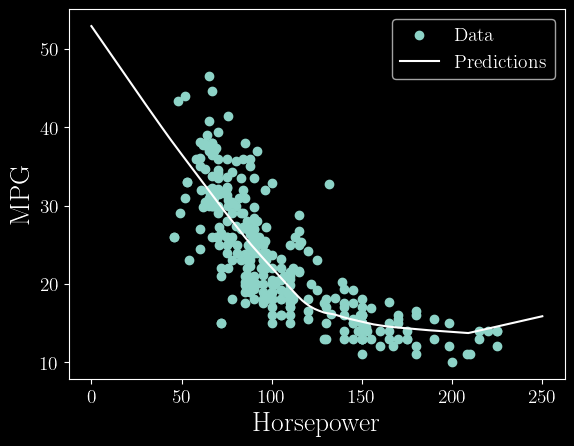

In [42]:
plot_horsepower(x, y, "horsepower_dnn_regress.pdf")

In [43]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["Horsepower"],
    test_labels,
    verbose=0,
)

In [44]:
# now for multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [45]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

2022-10-24 16:53:10.520075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:53:10.644596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.03 s, sys: 1.51 s, total: 4.54 s
Wall time: 3.6 s


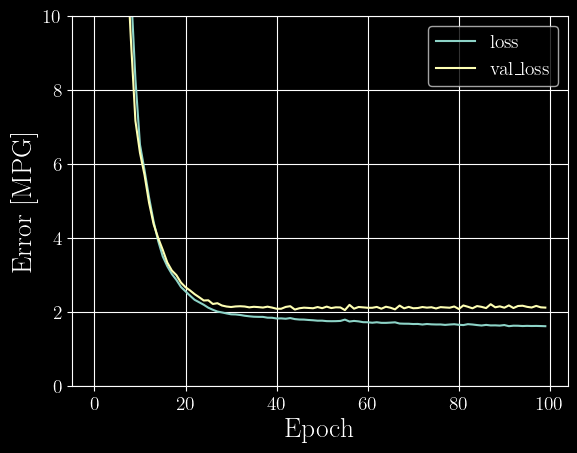

In [46]:
plot_loss(history, "dnn_loss.pdf")

In [47]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [48]:
pd.DataFrame(test_results, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepower_model,3.639057
linear_model,2.513399
dnn_horsepower_model,2.889445
dnn_model,1.727300


3/3 [==============================] - 0s 5ms/step


2022-10-24 16:55:32.195096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


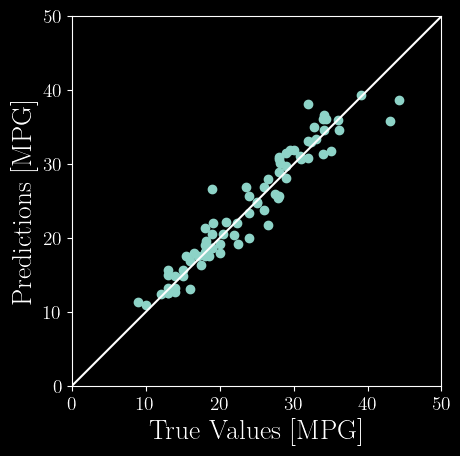

In [49]:
# compare true values and predicted values for test set!
test_predictions = dnn_model.predict(test_features).flatten()

fig = plt.figure()
ax = plt.gca()
ax.set_aspect("equal")
ax.scatter(test_labels, test_predictions)
ax.set_xlabel("True Values [MPG]", fontsize=20)
ax.set_ylabel("Predictions [MPG]", fontsize=20)
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(axis="both", labelsize=14)
# plot one-to-one line
_ = ax.plot(lims, lims, color="w")
fig.savefig("value_comparison.pdf", bbox_inches="tight", transparent=True)

3/3 [==============================] - 0s 2ms/step


2022-10-24 16:56:27.251920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:56:27.297454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-24 16:56:27.340564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


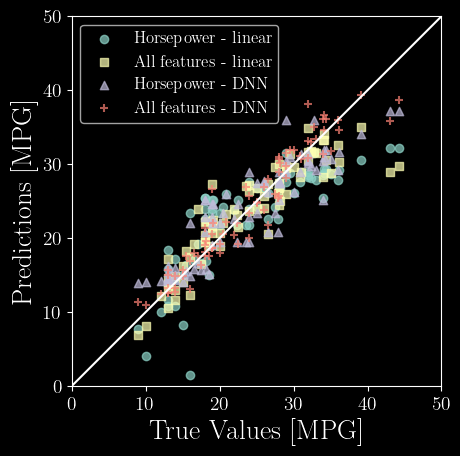

In [50]:
# see how predictions change for different models!
test_predictions_horsepower_lin = horsepower_model.predict(test_features["Horsepower"]).flatten()
test_predictions_lin = linear_model.predict(test_features).flatten()
test_predictions_horsepower_dnn = dnn_horsepower_model.predict(test_features["Horsepower"]).flatten()
test_predictions_dnn = dnn_model.predict(test_features).flatten()

fig = plt.figure()
ax = plt.gca()
ax.set_aspect("equal")
ax.scatter(
    test_labels,
    test_predictions_horsepower_lin,
    color="C0",
    label="Horsepower - linear",
    marker="o",
    alpha=0.7,
)
ax.scatter(
    test_labels,
    test_predictions_lin,
    color="C1",
    label="All features - linear",
    marker="s",
    alpha=0.7,
)
ax.scatter(
    test_labels,
    test_predictions_horsepower_dnn,
    color="C2",
    label="Horsepower - DNN",
    marker="^",
    alpha=0.7,
)
ax.scatter(
    test_labels,
    test_predictions_dnn,
    color="C3",
    label="All features - DNN",
    marker="+",
    alpha=0.7,
)
ax.set_xlabel("True Values [MPG]", fontsize=20)
ax.set_ylabel("Predictions [MPG]", fontsize=20)
lims = [0, 50]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(axis="both", labelsize=14)
ax.legend(loc=0, fontsize=12)
# plot one-to-one line
_ = ax.plot(lims, lims, color="w")

fig.savefig("comparison_all.pdf", bbox_inches="tight", transparent=True)